# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import os, sys

import numpy as np
import matplotlib.pyplot as plt
import torch

from collections import namedtuple 

from unityagents import UnityEnvironment

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
steps = 0

while True:
    steps += 1
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}, Steps:{}".format(score, steps))

Score: 0.0, Steps:300


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
class BananaNetQLearner(torch.nn.Module):
    """
    Fully connected network to solve Banana problem
    """
    
    def __init__(self, state_size=5, fcn1=128, fcn2=64, action_size=3):
        super().__init__()
        
        
        self.fcn1   = torch.nn.Linear(state_size, fcn1)
        self.fcn2   = torch.nn.Linear(fcn1, fcn2)
        self.out    = torch.nn.Linear(fcn2, action_size)

    def forward(self, x):
        
        x = self.fcn1(x)
        x = torch.nn.functional.relu(x)
        x = self.fcn2(x)
        x = torch.nn.functional.relu(x)
        x = self.out(x)
        
        return x      

In [8]:
class ExperienceBuffer():
    
    def __init__(self, batch_size=8, buffer_length=16, state_size=5, _action_size=1, _reward_size=1, _isdone_size=1):
        
        self.batch_size = batch_size
        self.buffer_length = buffer_length
        self.collected_samples = 0
        
        self.current_states = np.array(np.zeros((buffer_length, state_size )), dtype=np.float32)
        self.next_states    = np.array(np.zeros((buffer_length, state_size )), dtype=np.float32)
        self.actions        = np.array(np.zeros((buffer_length, _action_size)), dtype=np.int64)
        self.rewards        = np.array(np.zeros((buffer_length, _reward_size)), dtype=np.float32)
        self.isdones        = np.array(np.zeros((buffer_length, _isdone_size)), dtype=np.float32)
        
        self.insertion_index = 0
        
    def insert(self, current_state, action, next_state, reward, isdone):
        
        self.current_states[self.insertion_index] = current_state
        self.next_states[self.insertion_index] = next_state
        self.actions[self.insertion_index] = action
        self.rewards[self.insertion_index] = reward
        self.isdones[self.insertion_index] = float(isdone)
        
        self.collected_samples = min(self.collected_samples + 1, self.buffer_length)
        
        if self.insertion_index >= (self.buffer_length - 1):
            self.insertion_index = 0
        else:
            self.insertion_index += 1
            
        #print(self.current_states)
            
    def sample(self):
        #print(min(self.buffer_length, self.collected_samples))
        indices = np.random.choice(min(self.buffer_length, self.collected_samples), self.batch_size)
        
        return {    'current_states':    self.current_states[indices],
                    'next_states':       self.next_states[indices],
                    'actions':           self.actions[indices],
                    'rewards':           self.rewards[indices],
                    'isdones':           self.isdones[indices]
               }

In [9]:
ProjectParameters = namedtuple('ProjectParameters', 
                                [
                                    'stop_at_average_reward',
                                    'tau', 
                                    'batch_size', 
                                    'gamma', 
                                    'lr', 
                                    'update_freq', 
                                    'episodes', 
                                    'print_every',
                                    'mean_window_size',
                                    'max_steps',
                                    'epsilon_start', 'epsilon_min', 'epsilon_decay',
                                    'update_type',
                                    'state_size', 'action_size',
                                    'fcn1', 'fcn2',
                                    'seed',
                                    'buffer_length'
                                ])

In [10]:
def update_kwargdict(kwargs, input_collection, elements):
    kwargs.update({elem:input_collection._asdict()[elem] for elem in elements})

In [14]:
class Agent():
    
    def __init__(self, env, pps, network_type=BananaNetQLearner, network_kwargs={}, expbuffer_kwargs={}):
        
        self.pps = pps
        torch.manual_seed(self.pps.seed)
        np.random.seed(self.pps.seed)

        update_kwargdict(network_kwargs, pps, ['state_size', 'fcn1', 'fcn2', 'action_size'])
        update_kwargdict(expbuffer_kwargs, pps, ['batch_size', 'buffer_length', 'state_size'])

        self.local_Q_table = network_type(**network_kwargs)
        self.target_Q_table = network_type(**network_kwargs)
        self.experience_buffer = ExperienceBuffer(**expbuffer_kwargs)
        self.env = env
        #env.seed(self.pps.seed)
        
        self.optimizer = torch.optim.Adam(self.local_Q_table.parameters(), lr=pps.lr)
        self.current_state = None
        self.current_isdone = False
        self.scores, self.durations = [], []
        self.flat_steps = 0
        self.updatefunc = self.tau_update if pps.update_type == 'tau' else self.full_update
        self.epsilon = pps.epsilon_start
        self.experience_buffer_min = pps.batch_size * 10
        self.max_steps = self.pps.max_steps

    def run_session(self):
        for episode in range(self.pps.episodes):
            self.run_episode()
            self.max_steps += 1 # first terminate episodes early, later relax this

            average_score = np.mean(self.scores[-self.pps.mean_window_size:])                

            if (episode+1) % self.pps.print_every == 0:
                print('Episode: {}... AvgLast{}Score: {:.5f}... AvgLast{}EpisodeDuration: {:.2f}... Epsilon: {:.4f}'.format( \
                    episode+1, 
                    self.pps.mean_window_size,
                    average_score,
                    self.pps.mean_window_size,
                    np.mean(self.durations[-self.pps.mean_window_size:]),
                    self.epsilon
                ))
            
            if average_score > self.pps.stop_at_average_reward:
                break
                      
        print('\nTraining Finished!!!\n Concluded at Episode: {} AvgLast{}Score: {:.5f}...'.format(
            episode+1, 
            self.pps.mean_window_size,    
            average_score
        ))     
        
    def run_episode(self): 
        vdata, self.current_isdone =  env.reset(train_mode=True)[brain_name], False
        self.current_state = vdata.vector_observations[0] 
        episode_step, episode_score = 0, 0
        self.epsilon = max(self.pps.epsilon_min, self.pps.epsilon_decay*self.epsilon)
        while not self.current_isdone and episode_step < self.max_steps:
            episode_score += self.step()
            episode_step += 1 
       
        self.durations.append(episode_step)        
        self.scores.append(episode_score)
        
    def step(self):       
        
        # step in the environment
        self.local_Q_table.train(False)
        action = self.select_action(self.current_state)
        vdata = self.env.step(action)[brain_name]
        next_state, reward, self.current_isdone = vdata.vector_observations[0], vdata.rewards[0], vdata.local_done[0]  
        
        # store
        self.experience_buffer.insert(self.current_state, action, next_state, reward, self.current_isdone)
        
        # learn
        if self.experience_buffer.collected_samples >= self.experience_buffer_min:
            self.local_Q_table.train(True)
            self.qlearn(**self.experience_buffer.sample())
            self.flat_steps += 1 # first go will be an update for sure, put it before to cancel

        # update
        self.current_state = next_state
        
        return reward
            
    def qlearn(self, current_states, next_states, actions, rewards, isdones): # input variables are M[batchsize, positive_size] 
        
        # convert numpy to tensors
        with torch.no_grad():
            current_states = torch.from_numpy(current_states).float()
            next_states = torch.from_numpy(next_states).float()
            actions = torch.from_numpy(actions).long()
            rewards = torch.from_numpy(rewards).float()
            isdones = torch.from_numpy(isdones).float()
            
        #print(actions.shape, current_states.shape, next_states.shape, rewards.shape, isdones.shape)

        # get q-s [batch, 1] for current and next state
        q_currents = (self.local_Q_table(current_states) # M[batchsize, actionsize]
                        .gather(1, actions) # M[batchsize, 1], remains attached to autograd!
                     )
        
                      
        q_nexts = (self.target_Q_table(next_states) # M[batchsize, actionsize]
                        .detach() 
                        .max(dim=1)[0] # V[batchsize] [0] -> values (later verions: .values)
                        .unsqueeze(1) # make M[batchsize, 1] matrix from vector 
                    )
        # calculate learning target value for current q-s [batch, 1]
        with torch.no_grad(): 
            q_currents_learning_target = rewards + self.pps.gamma * q_nexts * (1. - isdones)
            
        # calculate loss
        loss = torch.nn.functional.mse_loss(q_currents, q_currents_learning_target)
        
        # backpropagate loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step() 
        
        # set target network
        if self.flat_steps % self.pps.update_freq == 0:
            self.updatefunc()
            
    def full_update(self):
        for target_param, local_param in zip(self.target_Q_table.parameters(), self.local_Q_table.parameters()):
            target_param.data.copy_(local_param.data)
            
    def tau_update(self):
        for target_param, local_param in zip(self.target_Q_table.parameters(), self.local_Q_table.parameters()):
            target_param.data.copy_(self.pps.tau * (local_param.data) + (1. - self.pps.tau) *target_param.data)    
                
    def select_action(self, current_state):
        if np.random.random() < self.epsilon:
            return np.random.choice([0,1,2,3])
        else:
            #print(current_state)
            return self.local_Q_table(torch.from_numpy(current_state).float().unsqueeze(0)).detach().max(dim=1)[1].item() # [1] -> indices

In [25]:
def plot_episode_scores(scores, target):
    score = plt.plot(scores, color='blue', label='Scores')
    avg100 = plt.plot(np.hstack([np.empty((100,)) * np.nan, np.convolve(scores, np.ones((100,))/100, mode='valid')]), color='orange', label='Mean(100)')
    target_ = plt.plot(np.ones((len(scores),)) * float(target), color='red', label='Target')
    
    plt.title("Learning Curve")
    plt.xlabel("Episode")
    plt.ylabel("Score")
    
    plt.legend()
    plt.show()

Episode: 10... AvgLast100Score: 3.50000... AvgLast100EpisodeDuration: 300.00... Epsilon: 0.0904
Episode: 20... AvgLast100Score: 5.25000... AvgLast100EpisodeDuration: 300.00... Epsilon: 0.0818
Episode: 30... AvgLast100Score: 6.23333... AvgLast100EpisodeDuration: 300.00... Epsilon: 0.0740
Episode: 40... AvgLast100Score: 6.60000... AvgLast100EpisodeDuration: 300.00... Epsilon: 0.0669
Episode: 50... AvgLast100Score: 6.88000... AvgLast100EpisodeDuration: 300.00... Epsilon: 0.0605
Episode: 60... AvgLast100Score: 7.35000... AvgLast100EpisodeDuration: 300.00... Epsilon: 0.0547
Episode: 70... AvgLast100Score: 7.52857... AvgLast100EpisodeDuration: 300.00... Epsilon: 0.0495
Episode: 80... AvgLast100Score: 7.82500... AvgLast100EpisodeDuration: 300.00... Epsilon: 0.0448
Episode: 90... AvgLast100Score: 8.01111... AvgLast100EpisodeDuration: 300.00... Epsilon: 0.0405
Episode: 100... AvgLast100Score: 8.38000... AvgLast100EpisodeDuration: 300.00... Epsilon: 0.0366
Episode: 110... AvgLast100Score: 9.1000

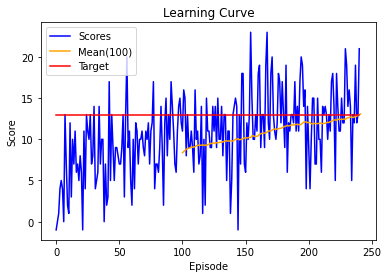

In [27]:
pps = ProjectParameters(
    #training parameters
        stop_at_average_reward=13.,
        tau=0.01, 
        batch_size=32, 
        gamma=0.95, 
        lr=0.0002, 
        update_freq=5,
        episodes=500,
        max_steps=300,
        epsilon_start=0.1,
        epsilon_min=0.01,
        epsilon_decay=0.99,
        update_type='full',
    #environment parameters
        state_size = 37,
        action_size = 4,        
    #network parameters
        fcn1 = 128,
        fcn2 = 64,
        seed = 0,
    #experience buffer parameters
        buffer_length = 20000,
    #communication parameters
        print_every=10,
        mean_window_size=100    
)

agent = Agent(env, pps=pps)
agent.run_session()

plot_episode_scores(agent.scores, 13.)

In [33]:
torch.save(agent.local_Q_table.state_dict(), 'navigation_state_dict_local.tsf')
torch.save(agent.target_Q_table.state_dict(), 'navigation_state_dict_target.tsf')